In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author Florian Wolling
Created on Thu May 23 14:15 2019
Edited on ...
"""

import os
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()
import pickle
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import matplotlib.pyplot as plt
import pandas as pd





In [5]:
#check keys of dictonary
dataset = pickle.load(open("sub01.p", "rb"))
for key in dataset['ex_walk']['forehead-wrist']['wrist']:
    print(key)
    
       

<class 'dict'>
note
t
ppg_g
ppg_y
pks_g
pks_y
acc_x
acc_y
acc_z


In [6]:
# butterworth bandpass filter

from scipy.signal import butter, lfilter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    #y = lfilter(b, a, data)
    return y


    

In [7]:
#detection of peaks and valleys
def peaksandvalleys(x,t,r):   
    global df1
    lowcut = 0.5    #band pass filter which stops frequencues less than 0.5 Hz and more than 5 Hz
    highcut = 15
    fs = 512
    pks[2] = [-i for i in pks[2]]
    y = list(butter_bandpass_filter(x, lowcut, highcut, fs, order=2))
    x =[-i for i in x] 
    y = [-i for i in y]               #invert the given signal

    L=250 #L-point filter
    b = (np.ones(L))/L           #numerator co-effs of filter transfer function
    a = np.ones(1)               #denominator co-effs of filter transfer function
    #y = signal.convolve(x,b)    #filter output using convolution
    z = list(lfilter(b,a,y))     #filter output using lfilter function

    p = 0   #store temporary peaks and valleys
    q = 0   #store specific time of peaks and valleys
    k = 0  #flag for valleys
    j = 0    #flag for peak

    peaksandvalleys = {'timepeaks':[],'timevalleys':[], 'peaks':[],'valleys':[]}

    for i in range(len(y)-1):
        if y[i] > z[i] and y[i+1] < y[i] and y[i] > y[i-1]:          #peaks: check 3 points, minimum when middle one is below than two other 
            if k != 0:
                k = 0
                peaksandvalleys['valleys'].append(p)       #store valleys
                peaksandvalleys['timevalleys'].append(q/512)              #store time of valleys
        
        
            if j != 0:            #checks second and more peaks and compare with previous peaks
                if y[i]-0 > p-0:  #only set if the peak is greater than previous peak
                    p = y[i]
                    q = i
                
            if j == 0:  # store first peaks in p and time in q
                p = y[i]
                q = i
                j += 1
            
        if y[i] < z[i] and y[i+1] > y[i] and y[i] < y[i-1]:  # check condition for valleys. valley should be less than its neighbouring points
            if j != 0:     
                j = 0
                peaksandvalleys['peaks'].append(p)      #store peaks
                peaksandvalleys['timepeaks'].append(q/512)             #store time of peaks
                
            if k != 0:                    #checks second and more valleys and compare with previous valley
                if y[i]-0 < p-0:          #only set if the valley is less than previous peak
                    p = y[i]
                    q = i
                
            if k == 0:                   # store first valley
                p = y[i]
                q = i
                k += 1
    if k !=0:
        peaksandvalleys['valleys'].append(p)        #store last valley
        peaksandvalleys['timevalleys'].append(q/512)               #store last time of  valley
        
    if j != 0:
        peaksandvalleys['peaks'].append(p)        #store last peak 
        peaksandvalleys['timepeaks'].append(q/512)               #store last time of peak 
# for plotting different signals
    if r =='plot':
        print('standard',len(pks[2]))
        print('determined',len( peaksandvalleys['valleys']))
        plt.figure()
        plt.plot(t,x,label='Original ppg signal')
        plt.legend(loc='upper right')
        plt.plot(pks[1],pks[2], color='r', linestyle='None', marker='^', markersize=4,)
        plt.figure()
        plt.plot(t,z,label='Moving average filter')
        plt.plot(t,y, label='Filtered signal with peaks and valleys', )
        plt.plot(peaksandvalleys['timepeaks'],peaksandvalleys['peaks'], color='k', linestyle='None', marker='^', markersize=4,)
        plt.plot(peaksandvalleys['timevalleys'],peaksandvalleys['valleys'], color='k', linestyle='None', marker='^', markersize=4,)
        plt.legend(loc='upper right')
        plt.show()
        return 0
    #print('\n'+r)
    #print('number of determined valleys',len(peaksandvalleys['timevalleys']))
    #print('number of standard valleys',len(pks[1]))
    beat1 = []
    beat2 = []

    truebeat = 0
    calculatedbeat =0
    for i in range(len(pks[1])-1):
        beat1.append(1/(pks[1][i+1]-pks[1][i]))
        truebeat = truebeat + 1/(pks[1][i+1]-pks[1][i])
    #print('average standard heart-beat')
    truebeat = truebeat / (len(pks[1])-1)
    #print(truebeat)
    
    for i in range(len(peaksandvalleys['timevalleys'])-1):
        beat2.append(1 / (peaksandvalleys['timevalleys'][i+1]-peaksandvalleys['timevalleys'][i]))
        calculatedbeat = calculatedbeat + 1 / (peaksandvalleys['timevalleys'][i+1]-peaksandvalleys['timevalleys'][i])
    #print('average determined heart-beat')
    calculatedbeat = calculatedbeat / (len(peaksandvalleys['timevalleys'])-1)
    #print(calculatedbeat)
    df1=[r,len(pks[1]),len(peaksandvalleys['timevalleys']),truebeat,calculatedbeat]
    beat =[beat1,beat2]
    return beat1,beat2
    
        

standard 278
determined 253


<IPython.core.display.Javascript object>


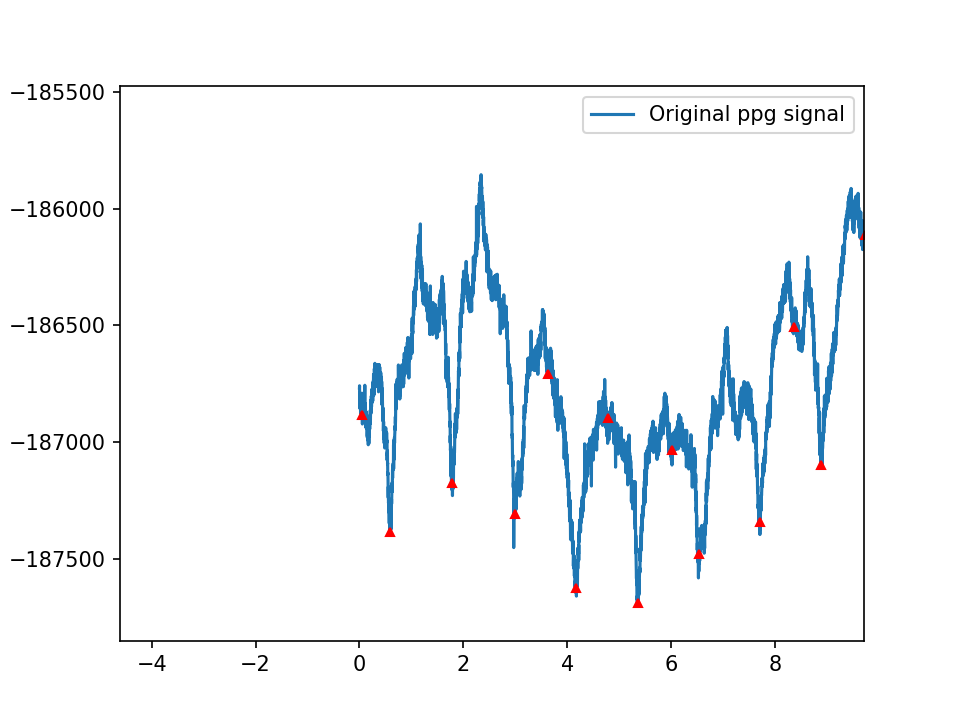

<IPython.core.display.Javascript object>


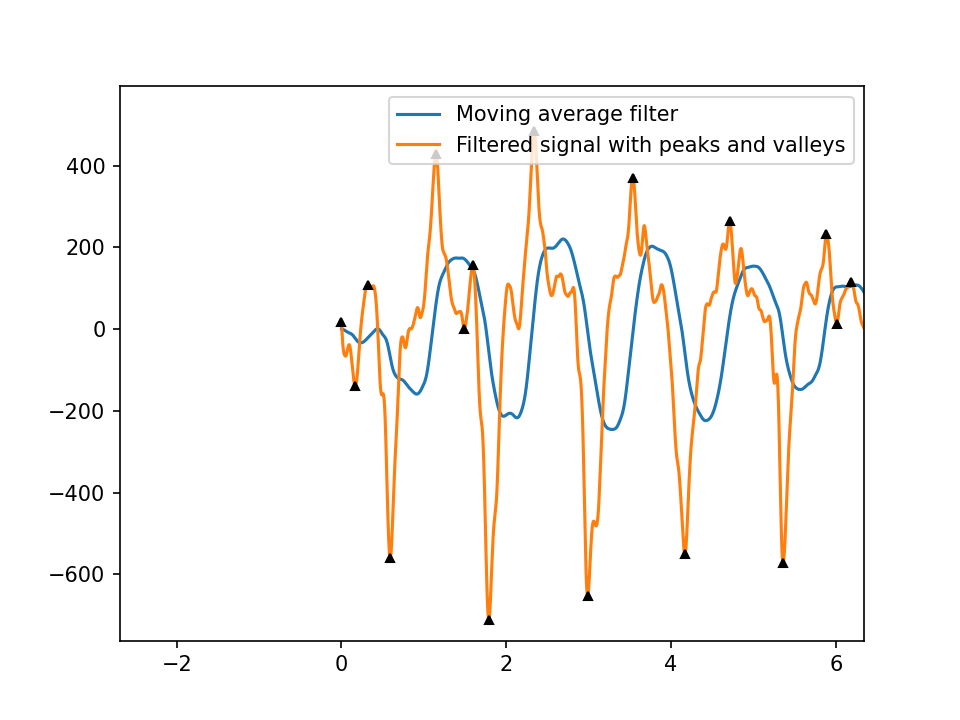

0

In [8]:
dataset = pickle.load(open("sub01.p", "rb"))
x = dataset['ex_walk']['forehead-wrist']['wrist']["ppg_g"]   #walking data set
t = dataset['ex_walk']['forehead-wrist']['wrist']["t"]
pks = dataset['ex_walk']['forehead-wrist']['wrist']["pks_g"]

peaksandvalleys(x,t,'plot')

<IPython.core.display.Javascript object>


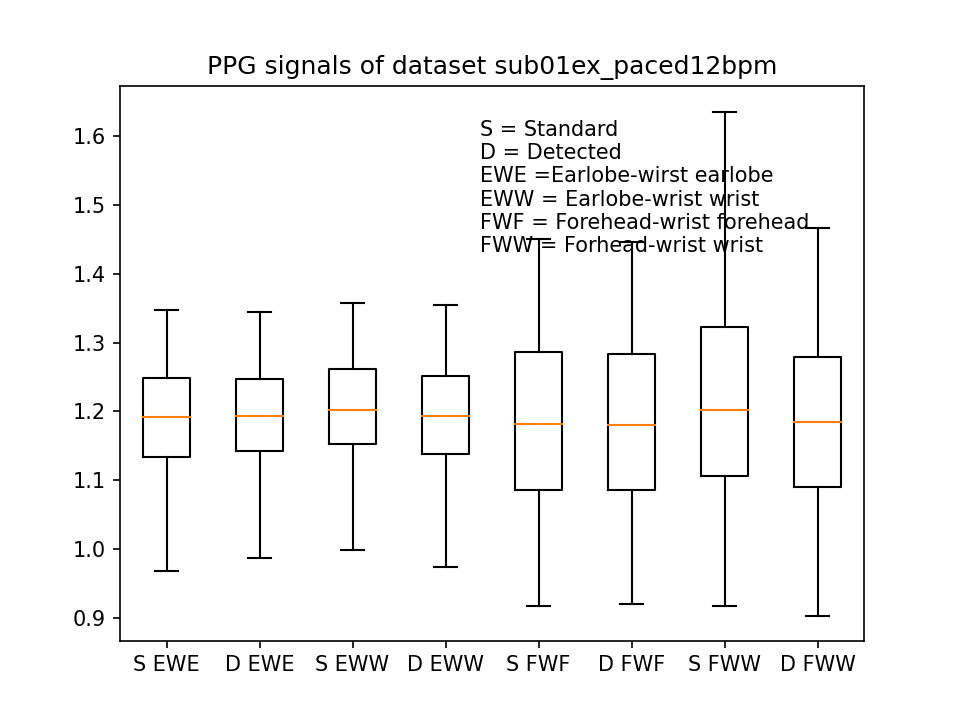

<IPython.core.display.Javascript object>


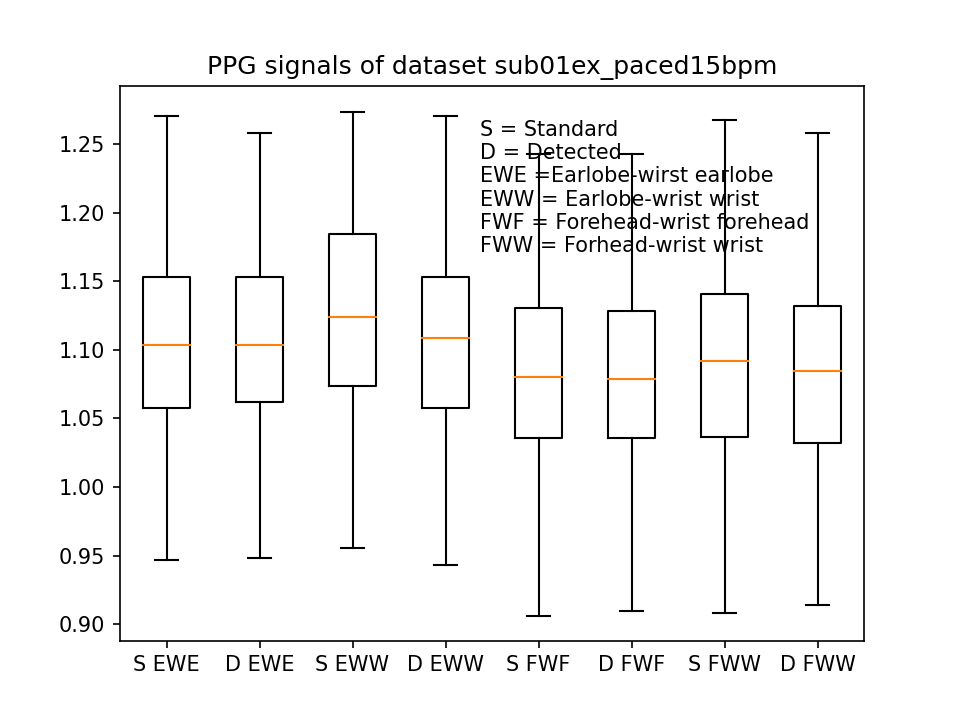

<IPython.core.display.Javascript object>


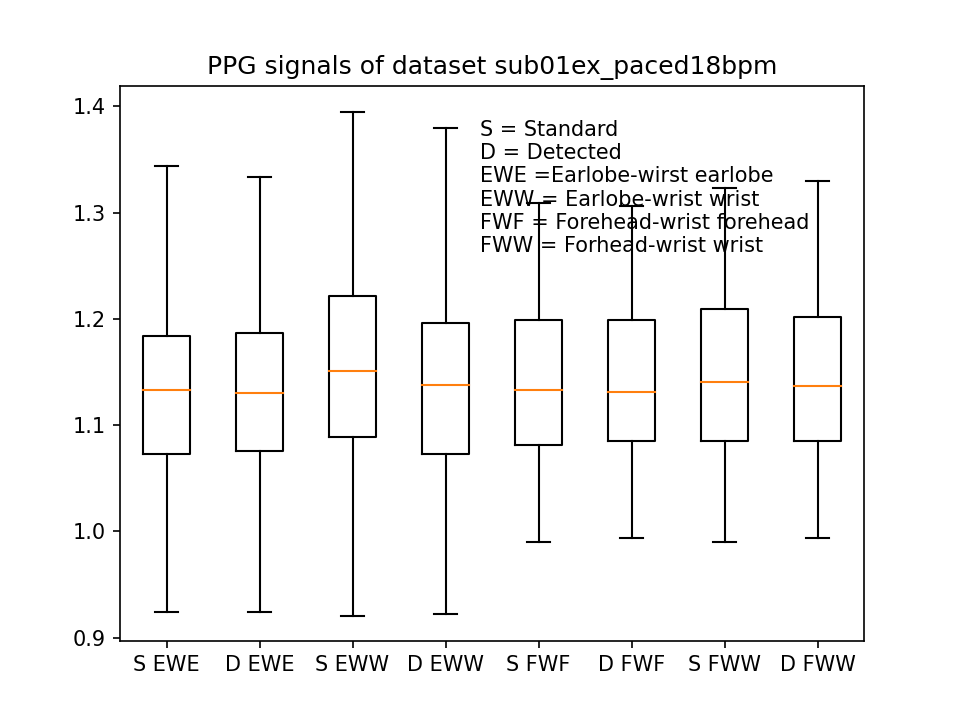

<IPython.core.display.Javascript object>


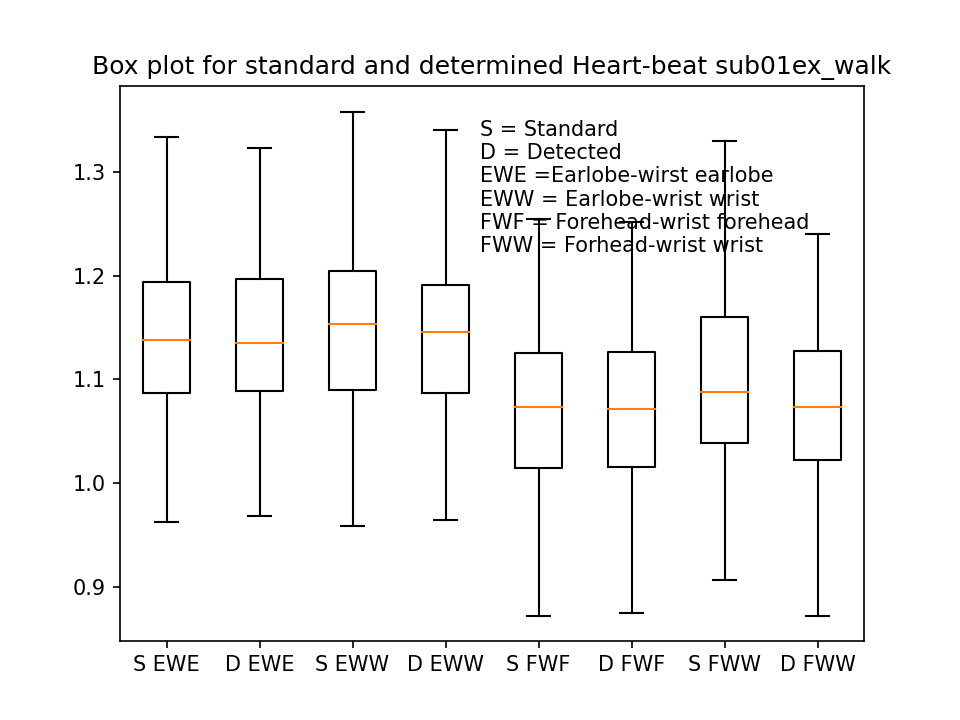

<IPython.core.display.Javascript object>


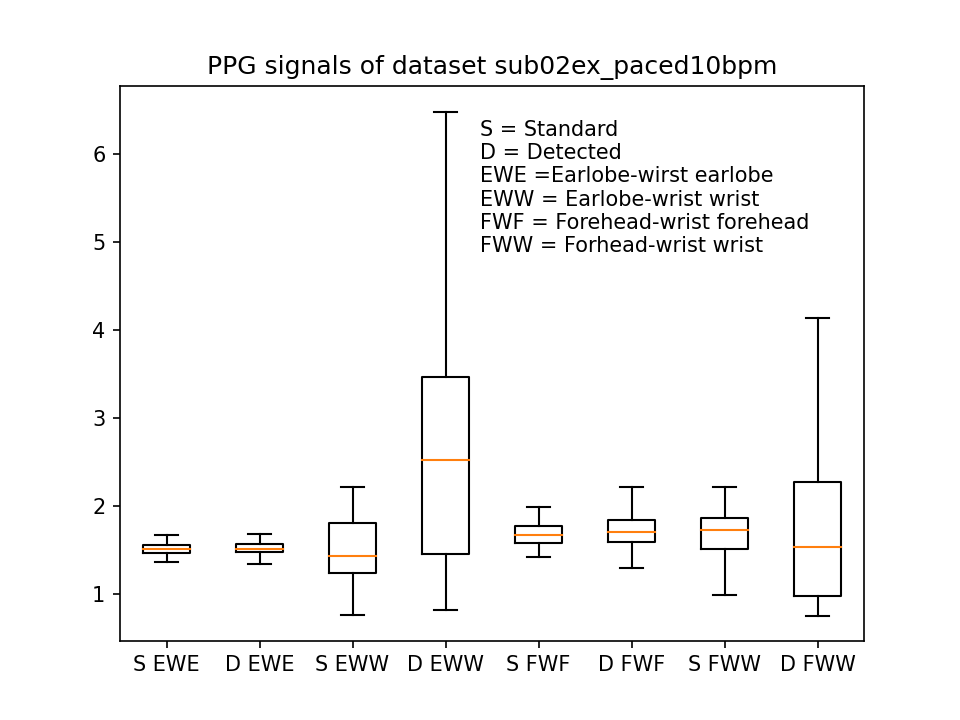

<IPython.core.display.Javascript object>


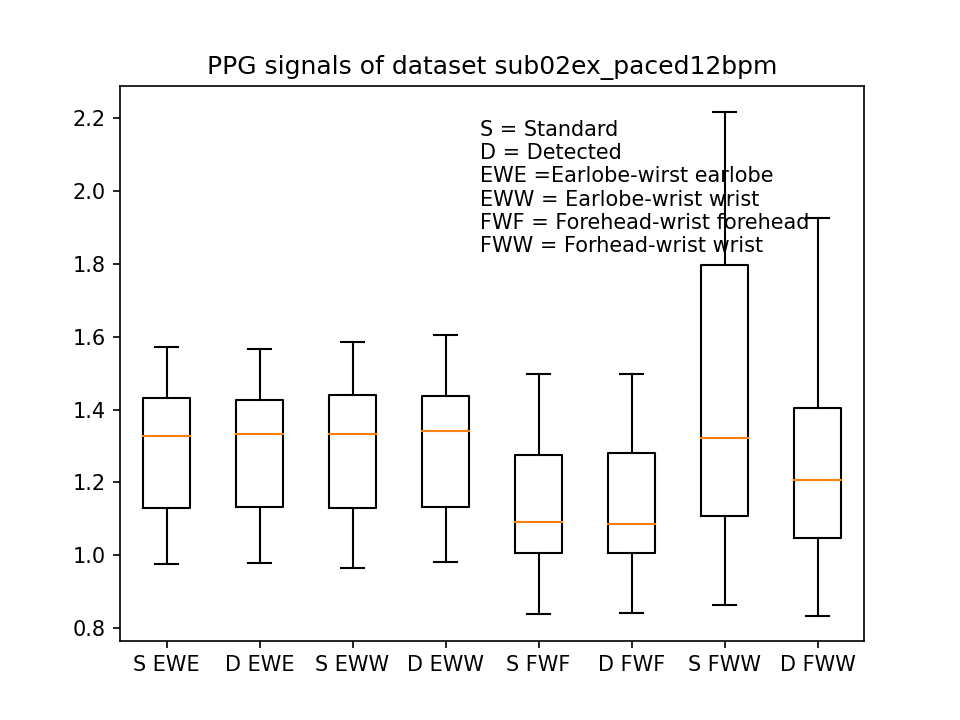

<IPython.core.display.Javascript object>


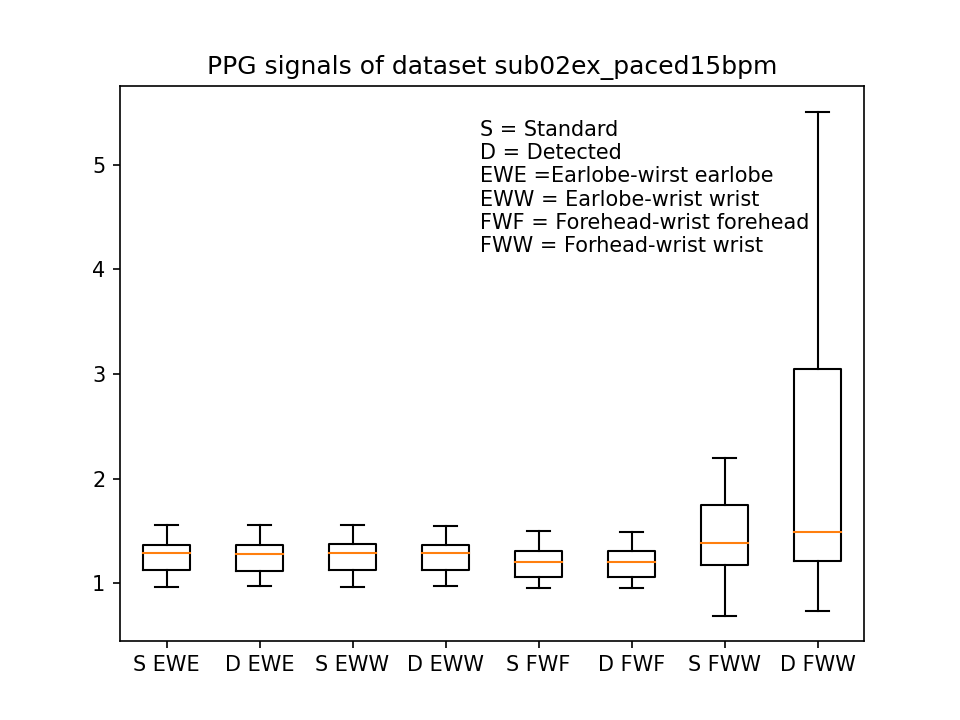

<IPython.core.display.Javascript object>


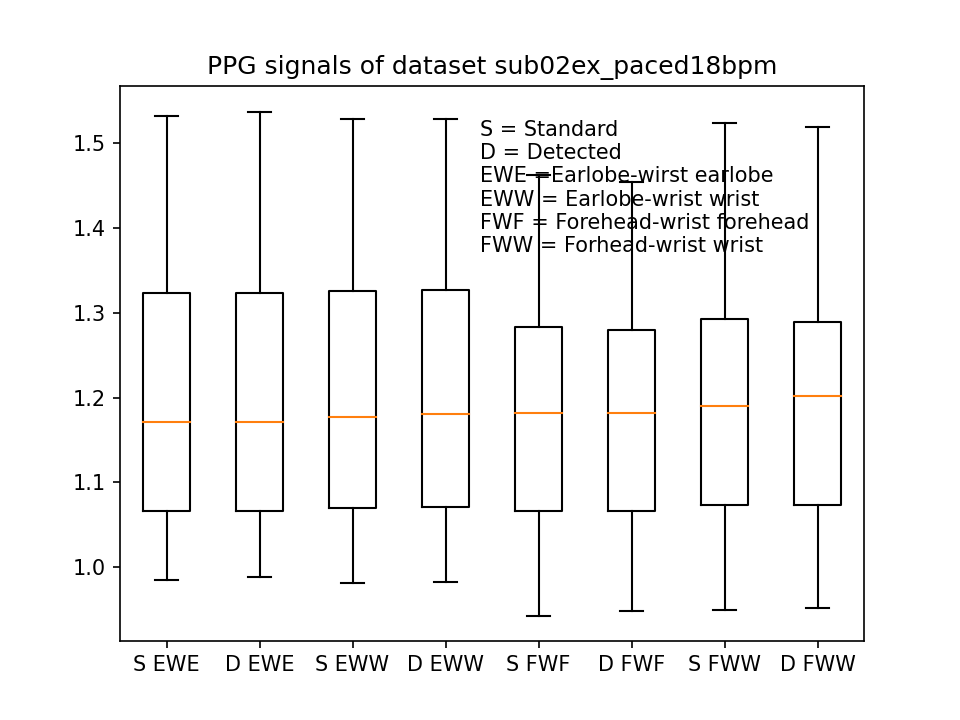

<IPython.core.display.Javascript object>


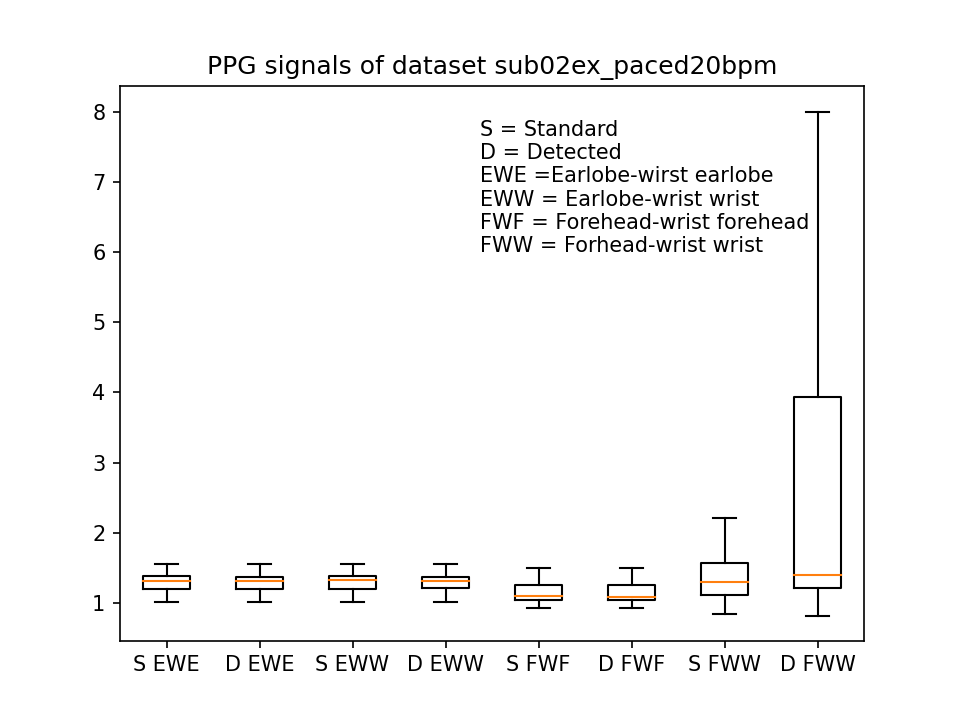

<IPython.core.display.Javascript object>


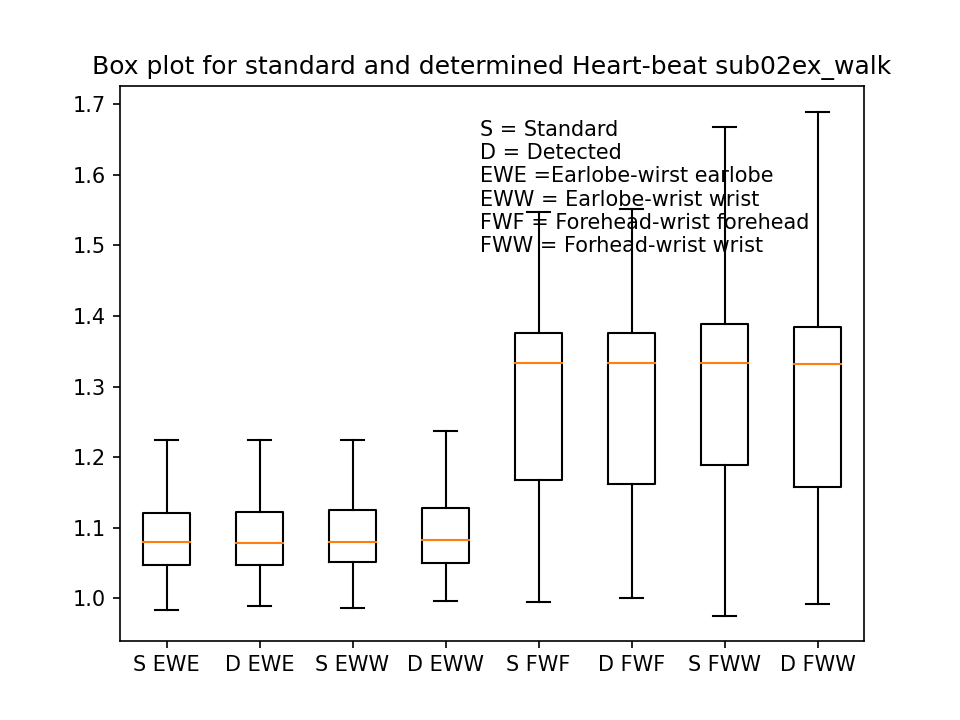

<IPython.core.display.Javascript object>


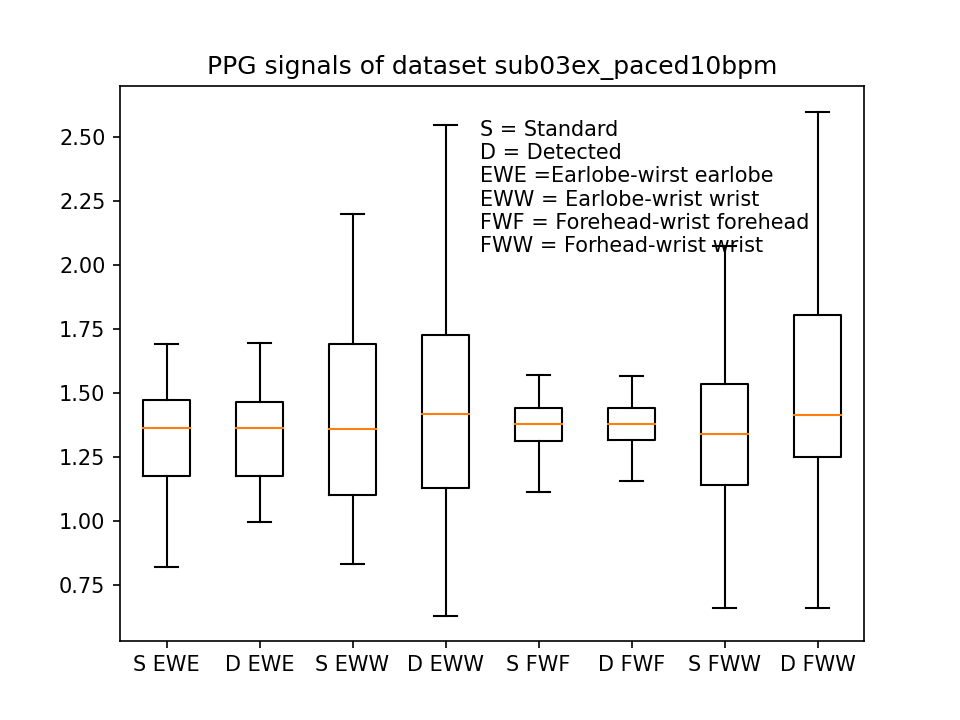

<IPython.core.display.Javascript object>


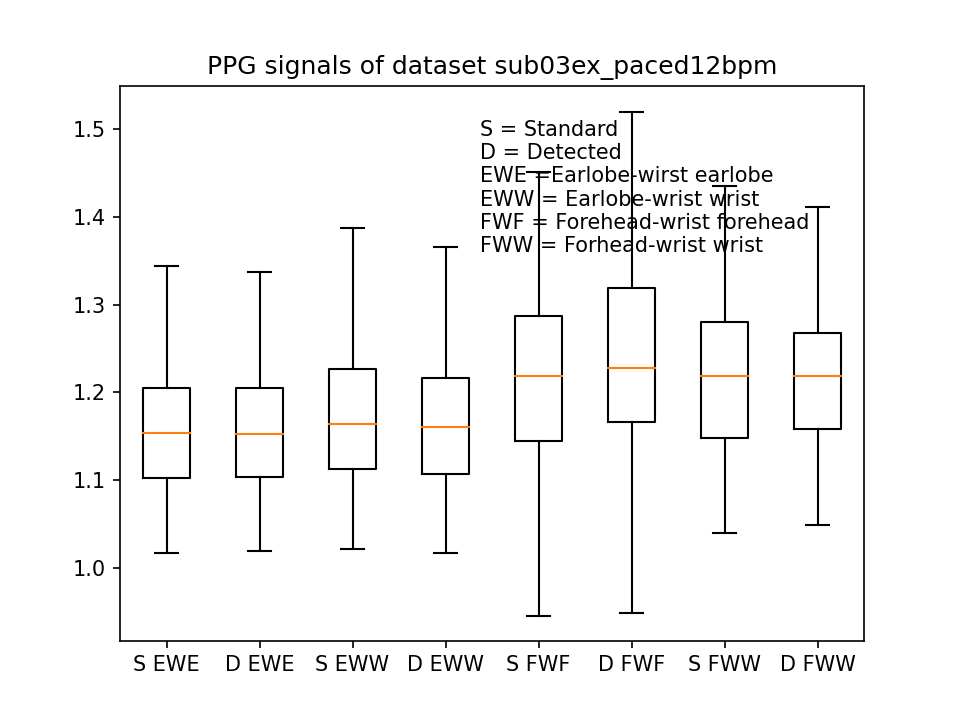

<IPython.core.display.Javascript object>


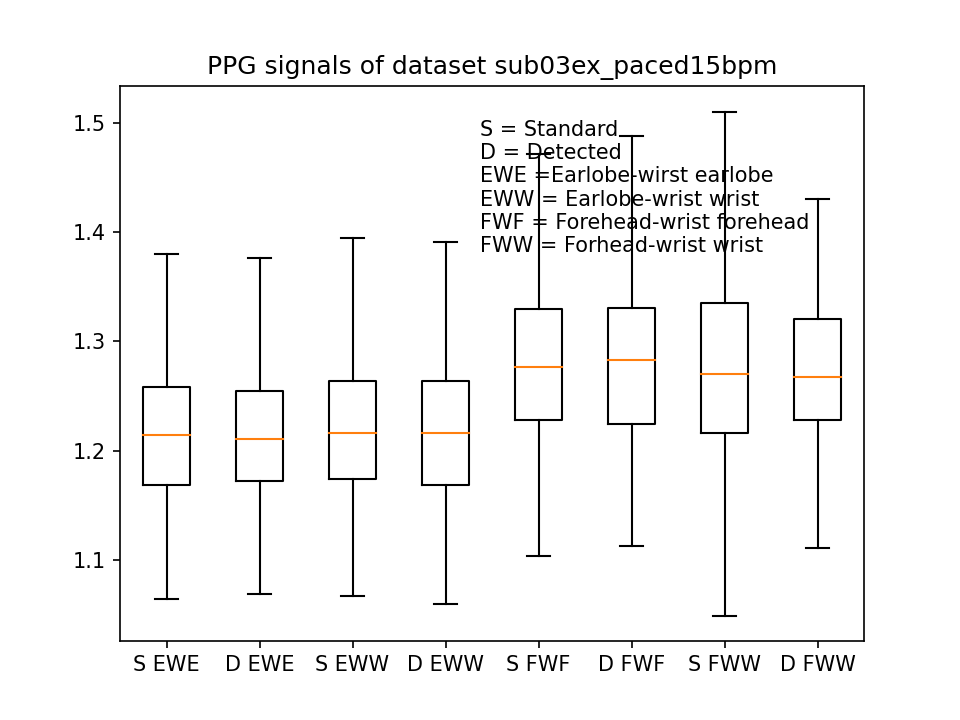

<IPython.core.display.Javascript object>


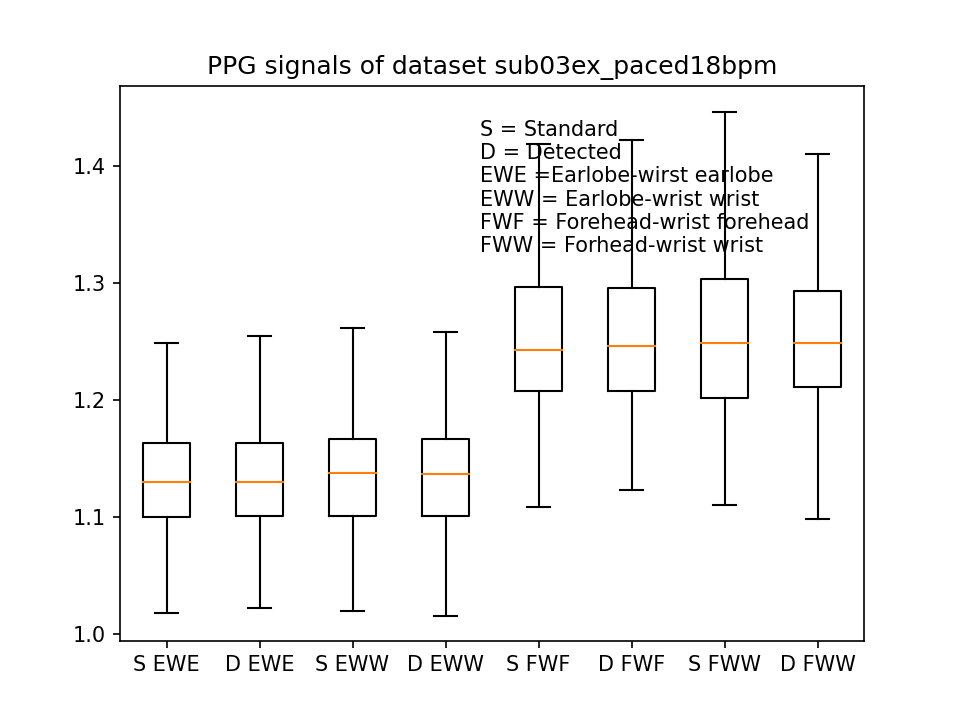

<IPython.core.display.Javascript object>


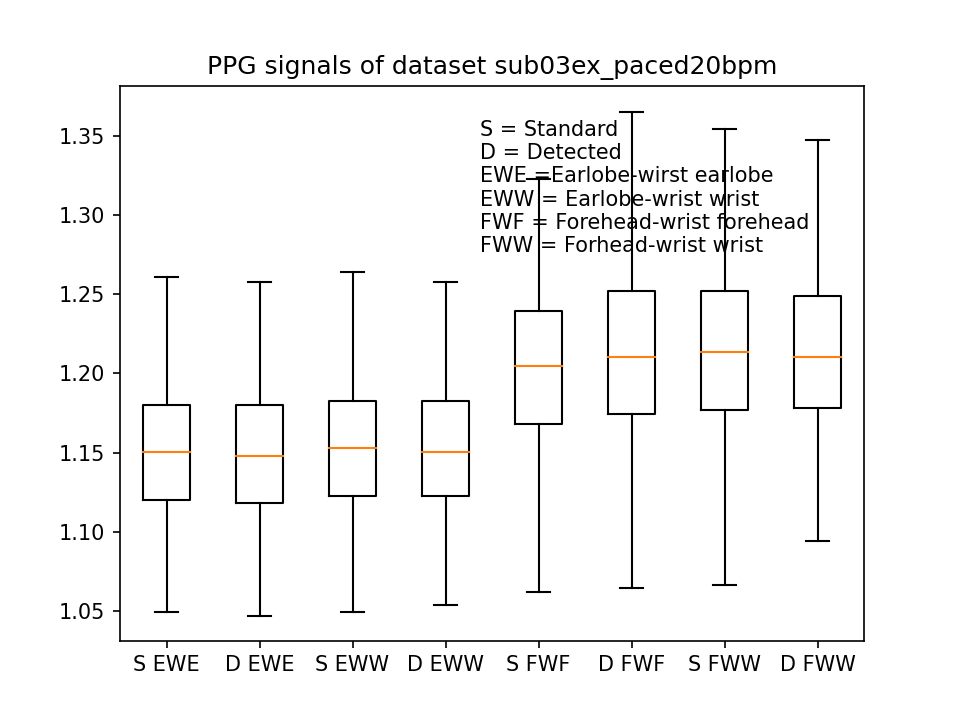

<IPython.core.display.Javascript object>


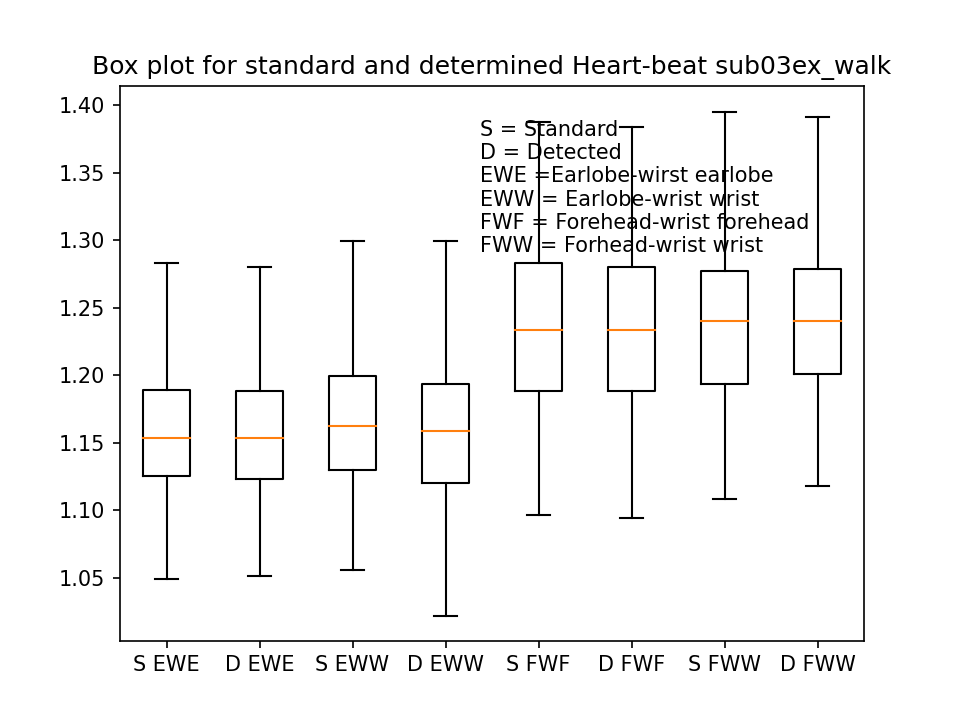

<IPython.core.display.Javascript object>


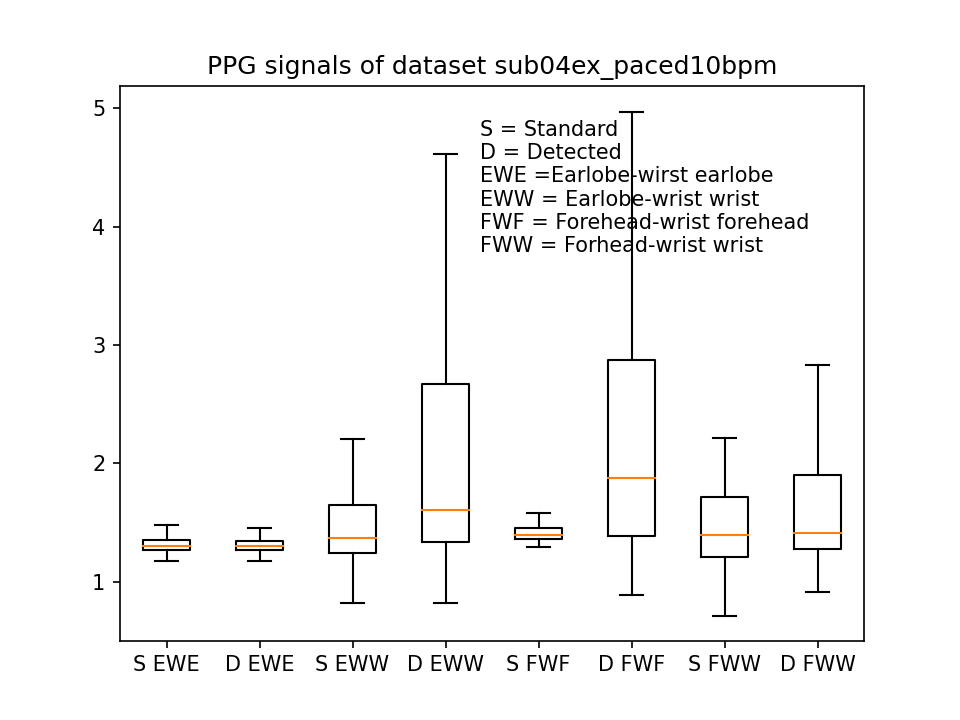

<IPython.core.display.Javascript object>


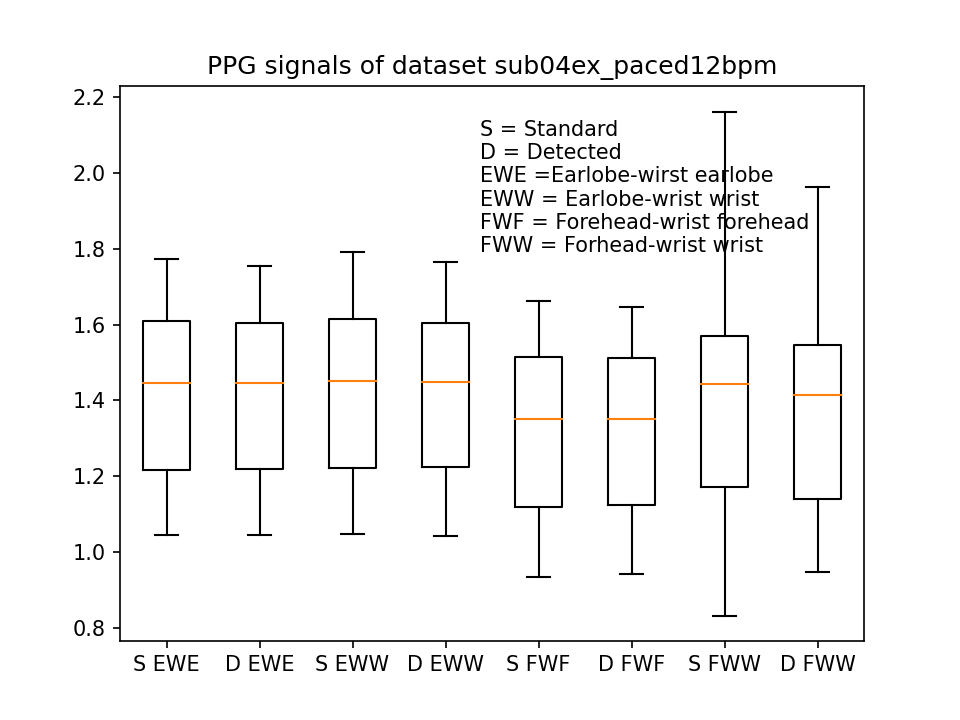

<IPython.core.display.Javascript object>


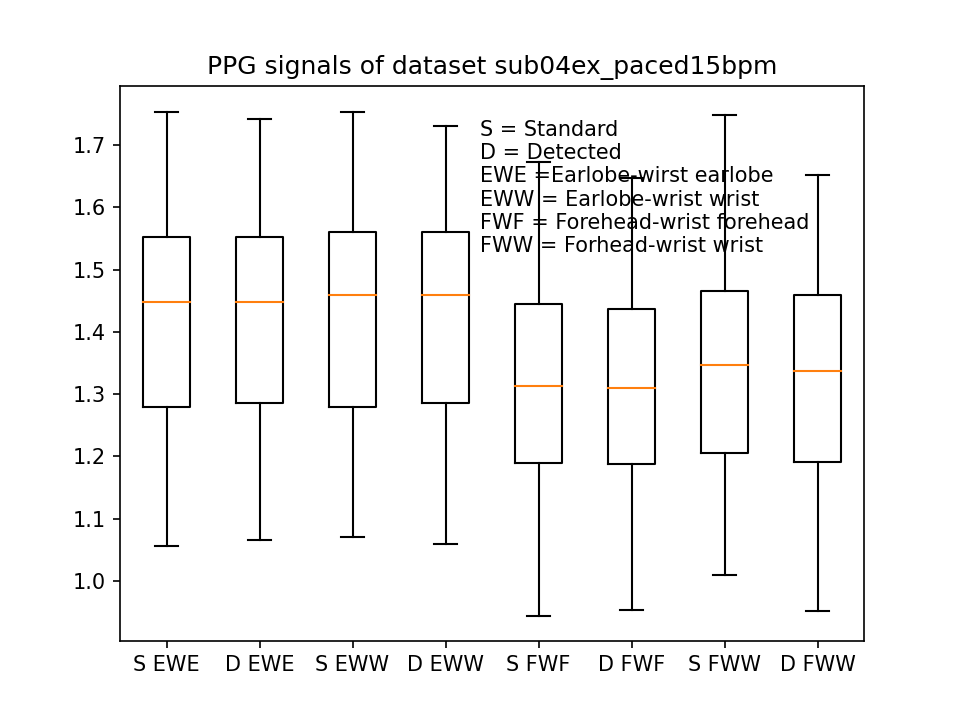

<IPython.core.display.Javascript object>


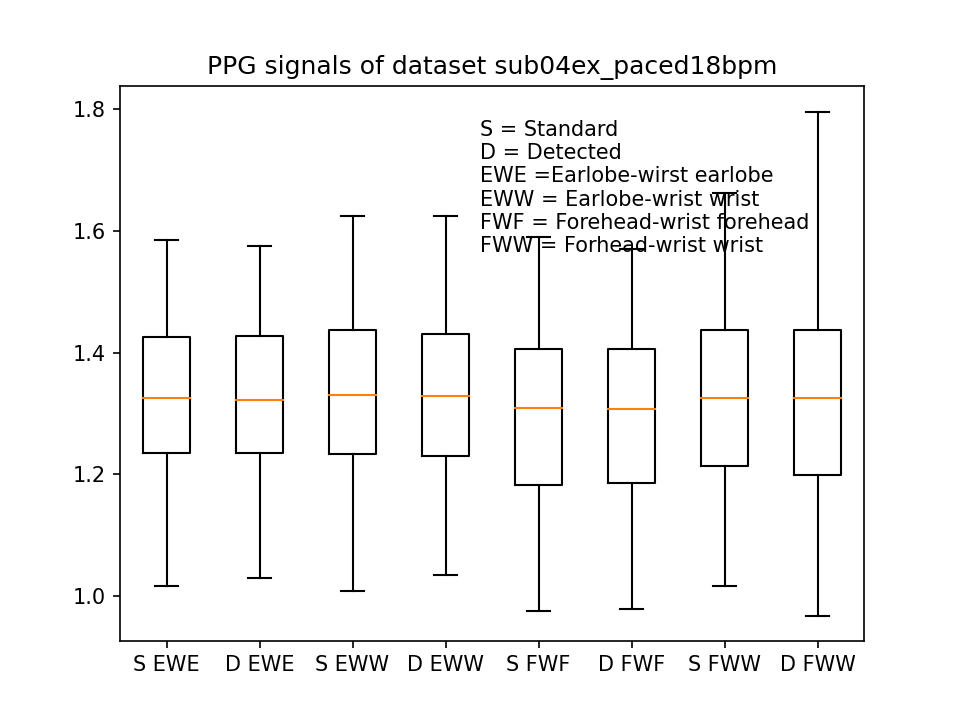

<IPython.core.display.Javascript object>


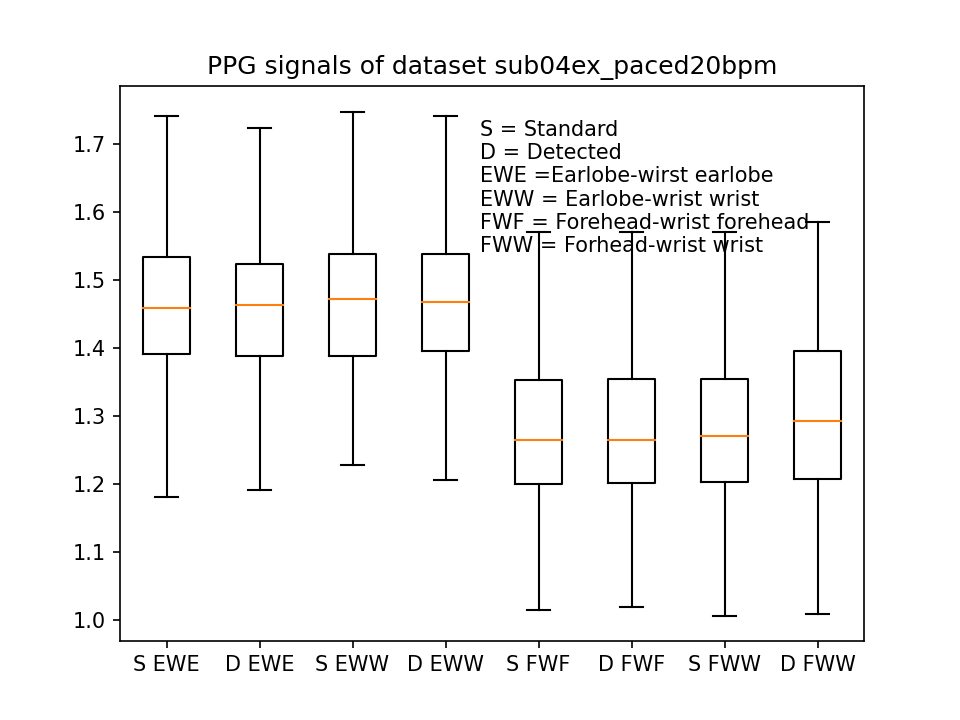

<IPython.core.display.Javascript object>


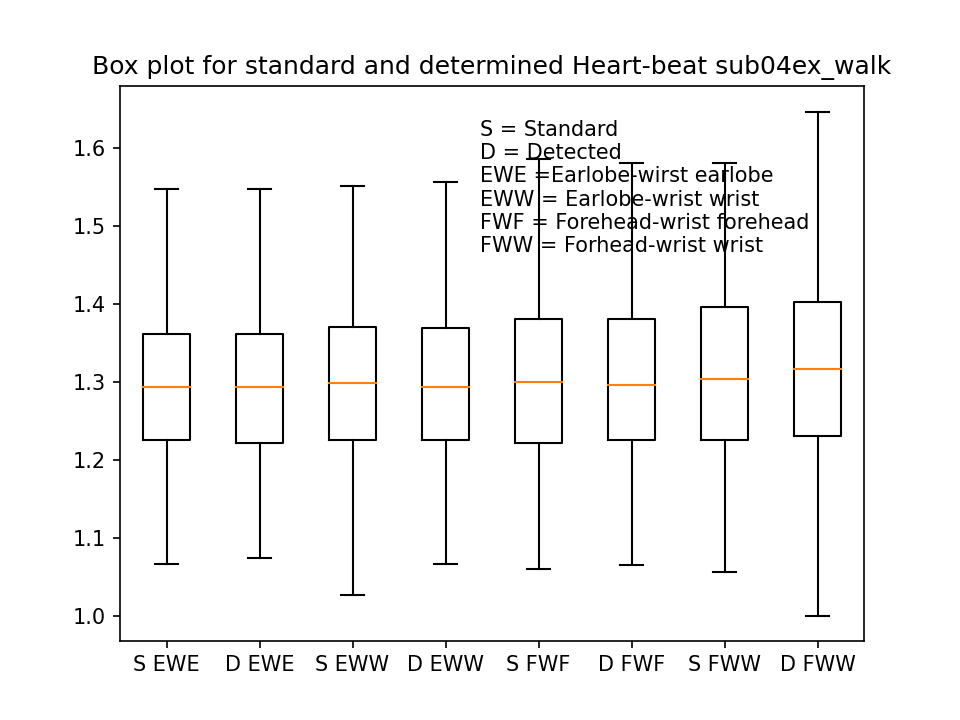

<IPython.core.display.Javascript object>


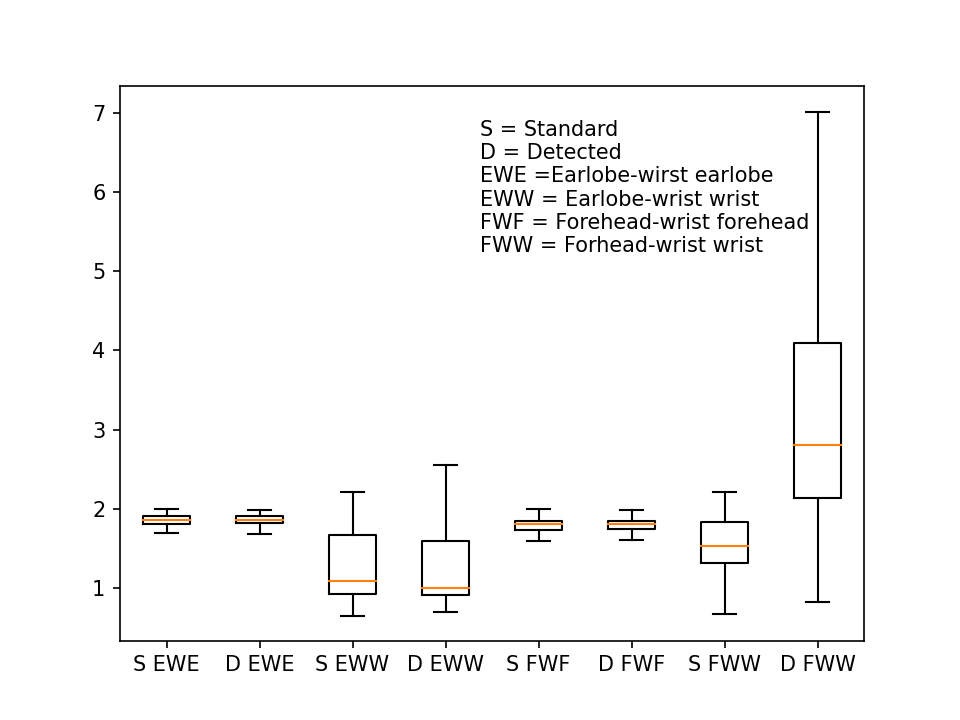

In [9]:


files = ["sub01","sub02","sub03","sub04"]  # Available dataset files.
df =[[]]
df2 = []
for file in files:  # Iterate through the available dataset files.
    
    dataset = pickle.load(open(str(file) + ".p", "rb"))  # Load the dataset.
    

    # PACED BREATHING

    experiment = "ex_paced"  # Select the paced breathing experiments.
    
    for ex in ["10bpm", "12bpm", "15bpm", "18bpm", "20bpm"]:  # Iterate through the available paced respiration rates.
        heartbeat = []
        
        #earlobe-wrist earlobe
        t = dataset[experiment][ex]["earlobe-wrist"]["earlobe"]["t"]
        x = dataset[experiment][ex]["earlobe-wrist"]["earlobe"]["ppg_g"]
        pks = dataset[experiment][ex]["earlobe-wrist"]["earlobe"]["pks_g"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1,beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+ex+" "+"earlobe-wrist earlobe")
            df2.extend(df1)
            heartbeat.append(beat1)
            heartbeat.append(beat2)
            
        t = dataset[experiment][ex]["earlobe-wrist"]["earlobe"]["t"]
        x = dataset[experiment][ex]["earlobe-wrist"]["earlobe"]["ppg_y"]
        pks = dataset[experiment][ex]["earlobe-wrist"]["earlobe"]["pks_y"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1,beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+ex+" "+"earlobe-wrist earlobe")
            df2.extend(df1)
            df.append(df2)
            df2 = []

            
        #earlobe-wrist wrist
            
        t = dataset[experiment][ex]["earlobe-wrist"]["wrist"]["t"]
        x = dataset[experiment][ex]["earlobe-wrist"]["wrist"]["ppg_g"]
        pks = dataset[experiment][ex]["earlobe-wrist"]["wrist"]["pks_g"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1,beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+ex+" "+"earlobe-wrist wrist")
            df2.extend(df1)
            heartbeat.append(beat1)
            heartbeat.append(beat2)
            
        t = dataset[experiment][ex]["earlobe-wrist"]["wrist"]["t"]
        x = dataset[experiment][ex]["earlobe-wrist"]["wrist"]["ppg_y"]
        pks = dataset[experiment][ex]["earlobe-wrist"]["wrist"]["pks_y"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1,beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+ex+" "+"earlobe-wrist wrist")
            df2.extend(df1)
            df.append(df2)
            df2 = []
            
        
        #forehead-wrist forehead
        t = dataset[experiment][ex]["forehead-wrist"]["forehead"]["t"]
        x = dataset[experiment][ex]["forehead-wrist"]["forehead"]["ppg_g"]
        pks = dataset[experiment][ex]["forehead-wrist"]["forehead"]["pks_g"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1,beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+ex+" "+"forehead-wrist forehead")
            df2.extend(df1)
            heartbeat.append(beat1)
            heartbeat.append(beat2)
            
        t = dataset[experiment][ex]["forehead-wrist"]["forehead"]["t"]
        x = dataset[experiment][ex]["forehead-wrist"]["forehead"]["ppg_y"]
        pks = dataset[experiment][ex]["forehead-wrist"]["forehead"]["pks_y"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1,beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+ex+" "+"forehead-wrist forehead")
            df2.extend(df1)
            df.append(df2)
            df2 = []
        
        #forehead-wrist wrist
        t = dataset[experiment][ex]["forehead-wrist"]["wrist"]["t"]
        x = dataset[experiment][ex]["forehead-wrist"]["wrist"]["ppg_g"]
        pks = dataset[experiment][ex]["forehead-wrist"]["wrist"]["pks_g"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1, beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+ex+" "+"forehead-wrist wrist")
            df2.extend(df1)
            heartbeat.append(beat1)
            heartbeat.append(beat2)
            
        t = dataset[experiment][ex]["forehead-wrist"]["wrist"]["t"]
        x = dataset[experiment][ex]["forehead-wrist"]["wrist"]["ppg_y"]
        pks = dataset[experiment][ex]["forehead-wrist"]["wrist"]["pks_y"]
        if len(pks) != 0:
            #plt.plot(pks[1], pks[2], color='red', linestyle='None', marker='o', markersize=3, alpha=1.0)
            beat1, beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+ex+" "+"forehead-wrist wrist")
            df2.extend(df1)
            df.append(df2)
            df2 = []

            plt.title("PPG signals of dataset " + file + experiment +ex)
            plt.figure()
            #plt.figtext('S = standard','D = determined',"EWE =Earlobe-wirst wirst "," EWE = Earlobe-wirst earlobe","FWF = Forehead-wirst forehead",
                       #'FWW = Forhead-wirst wirst')
            plt.figtext(0.5, 0.65, "S = Standard\nD = Detected\nEWE =Earlobe-wirst earlobe\nEWW = Earlobe-wrist wrist\nFWF = Forehead-wrist forehead\nFWW = Forhead-wrist wrist ")
            plt.boxplot(heartbeat,labels = ['S EWE','D EWE','S EWW','D EWW','S FWF','D FWF','S FWW','D FWW'],showfliers=False)
            plt.show()
       
        heartbeat = []

    # WALKING

    experiment = "ex_walk"  # Select the walking experiments.
    
    #earlobe-wrist earlobe

    t = dataset[experiment]["earlobe-wrist"]["earlobe"]["t"]
    x = dataset[experiment]["earlobe-wrist"]["earlobe"]["ppg_g"]
    pks = dataset[experiment]["earlobe-wrist"]["earlobe"]["pks_g"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+"earlobe-wrist earlobe")
    df2.extend(df1)
    heartbeat.append(beat1)
    heartbeat.append(beat2)  
    
    t = dataset[experiment]["earlobe-wrist"]["earlobe"]["t"]
    x = dataset[experiment]["earlobe-wrist"]["earlobe"]["ppg_y"]
    pks = dataset[experiment]["earlobe-wrist"]["earlobe"]["pks_y"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+"earlobe-wrist earlobe")
    df2.extend(df1)
    df.append(df2)
    df2 = []
    
    #earlobe-wrist wrist

    t = dataset[experiment]["earlobe-wrist"]["wrist"]["t"]
    x = dataset[experiment]["earlobe-wrist"]["wrist"]["ppg_g"]
    pks = dataset[experiment]["earlobe-wrist"]["wrist"]["pks_g"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+"earlobe-wrist wrist")
    df2.extend(df1)
    heartbeat.append(beat1)
    heartbeat.append(beat2)
    
    t = dataset[experiment]["earlobe-wrist"]["wrist"]["t"]
    x = dataset[experiment]["earlobe-wrist"]["wrist"]["ppg_y"]
    pks = dataset[experiment]["earlobe-wrist"]["wrist"]["pks_y"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+"earlobe-wrist wrist")
    df2.extend(df1)
    df.append(df2)
    df2 = []
    
    #forehead-wrist forehead

    t = dataset[experiment]["forehead-wrist"]["forehead"]["t"]
    x = dataset[experiment]["forehead-wrist"]["forehead"]["ppg_g"]
    pks = dataset[experiment]["forehead-wrist"]["forehead"]["pks_g"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+"forehead-wrist forehead")
    df2.extend(df1)
    heartbeat.append(beat1)
    heartbeat.append(beat2)
    
    t = dataset[experiment]["forehead-wrist"]["forehead"]["t"]
    x = dataset[experiment]["forehead-wrist"]["forehead"]["ppg_y"]
    pks = dataset[experiment]["forehead-wrist"]["forehead"]["pks_y"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_y'+" "+file+" "+experiment+" "+"forehead-wrist forehead")
    df2.extend(df1)
    df.append(df2)
    df2 = []
    
    #forehead-wrist wrist

    t = dataset[experiment]["forehead-wrist"]["wrist"]["t"]
    x = dataset[experiment]["forehead-wrist"]["wrist"]["ppg_g"]
    pks = dataset[experiment]["forehead-wrist"]["wrist"]["pks_g"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+"forehead-wrist wrist")
    df2.extend(df1)
    heartbeat.append(beat1)
    heartbeat.append(beat2)
    
    t = dataset[experiment]["forehead-wrist"]["wrist"]["t"]
    x = dataset[experiment]["forehead-wrist"]["wrist"]["ppg_g"]
    pks = dataset[experiment]["forehead-wrist"]["wrist"]["pks_g"]
    beat1, beat2 = peaksandvalleys(x,t,'ppg_g'+" "+file+" "+experiment+" "+"forehead-wrist wrist")
    df2.extend(df1)
    df.append(df2)
    df2 = []
    
    plt.title("Box plot for standard and determined Heart-beat " + file + experiment)
    plt.figure()
    plt.figtext(0.5, 0.65, "S = Standard\nD = Detected\nEWE =Earlobe-wirst earlobe\nEWW = Earlobe-wrist wrist\nFWF = Forehead-wrist forehead\nFWW = Forhead-wrist wrist ")
    plt.boxplot(heartbeat,labels = ['S EWE','D EWE','S EWW','D EWW','S FWF','D FWF','S FWW','D FWW'],showfliers=False)
    plt.show()
df.pop(0)

df = pd.DataFrame(df,columns=['gTiltle','gNo of standard valleys','gNo of determined valleys',
                              'gAverage standard heart-beat(Hz)','gAverage determined heart-beat(Hz)',
                               'yTiltle','yNo of standard valleys','yNo of determined valleys',
                              'yAverage standard heart-beat(Hz)','yAverage determined heart-beat(Hz)'])

#dfy = pd.DataFrame(dfy,columns=['Tiltle','No of standard valleys','No of determined valleys',
                              #'Average standard valleys(Hz)','Average determined valleys(Hz)'])



<IPython.core.display.Javascript object>


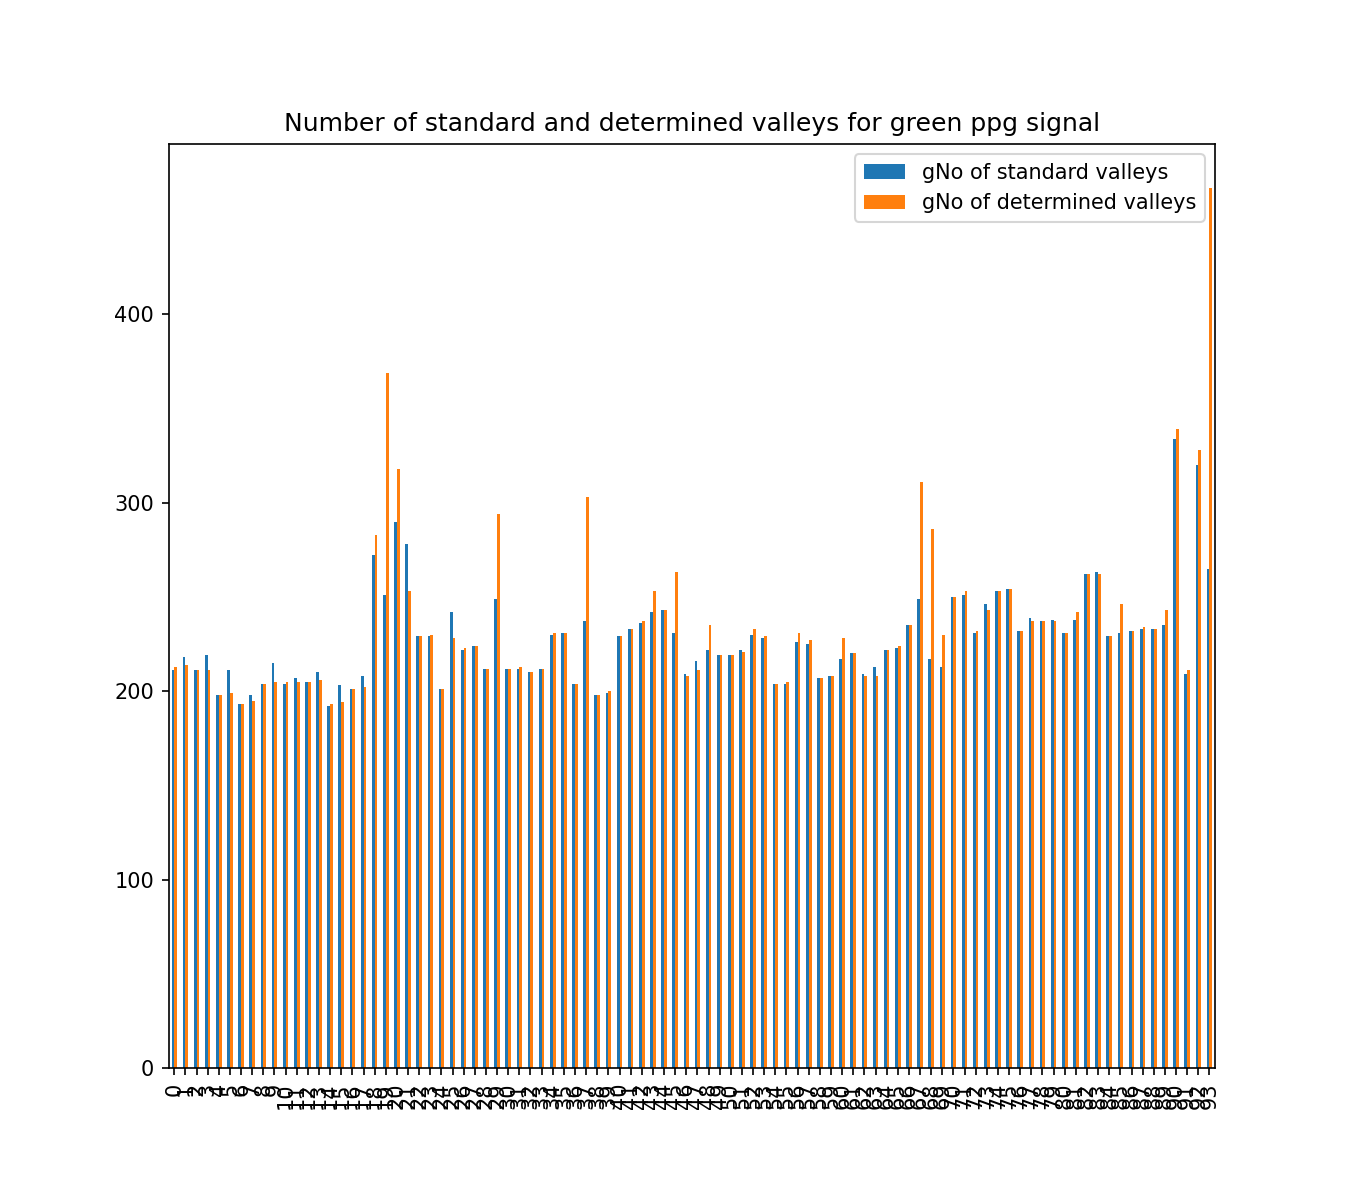

In [10]:
df.plot(y=["gNo of standard valleys", "gNo of determined valleys"], kind="bar",figsize=(9,8))
plt.title('Number of standard and determined valleys for green ppg signal')
plt.show()

<IPython.core.display.Javascript object>


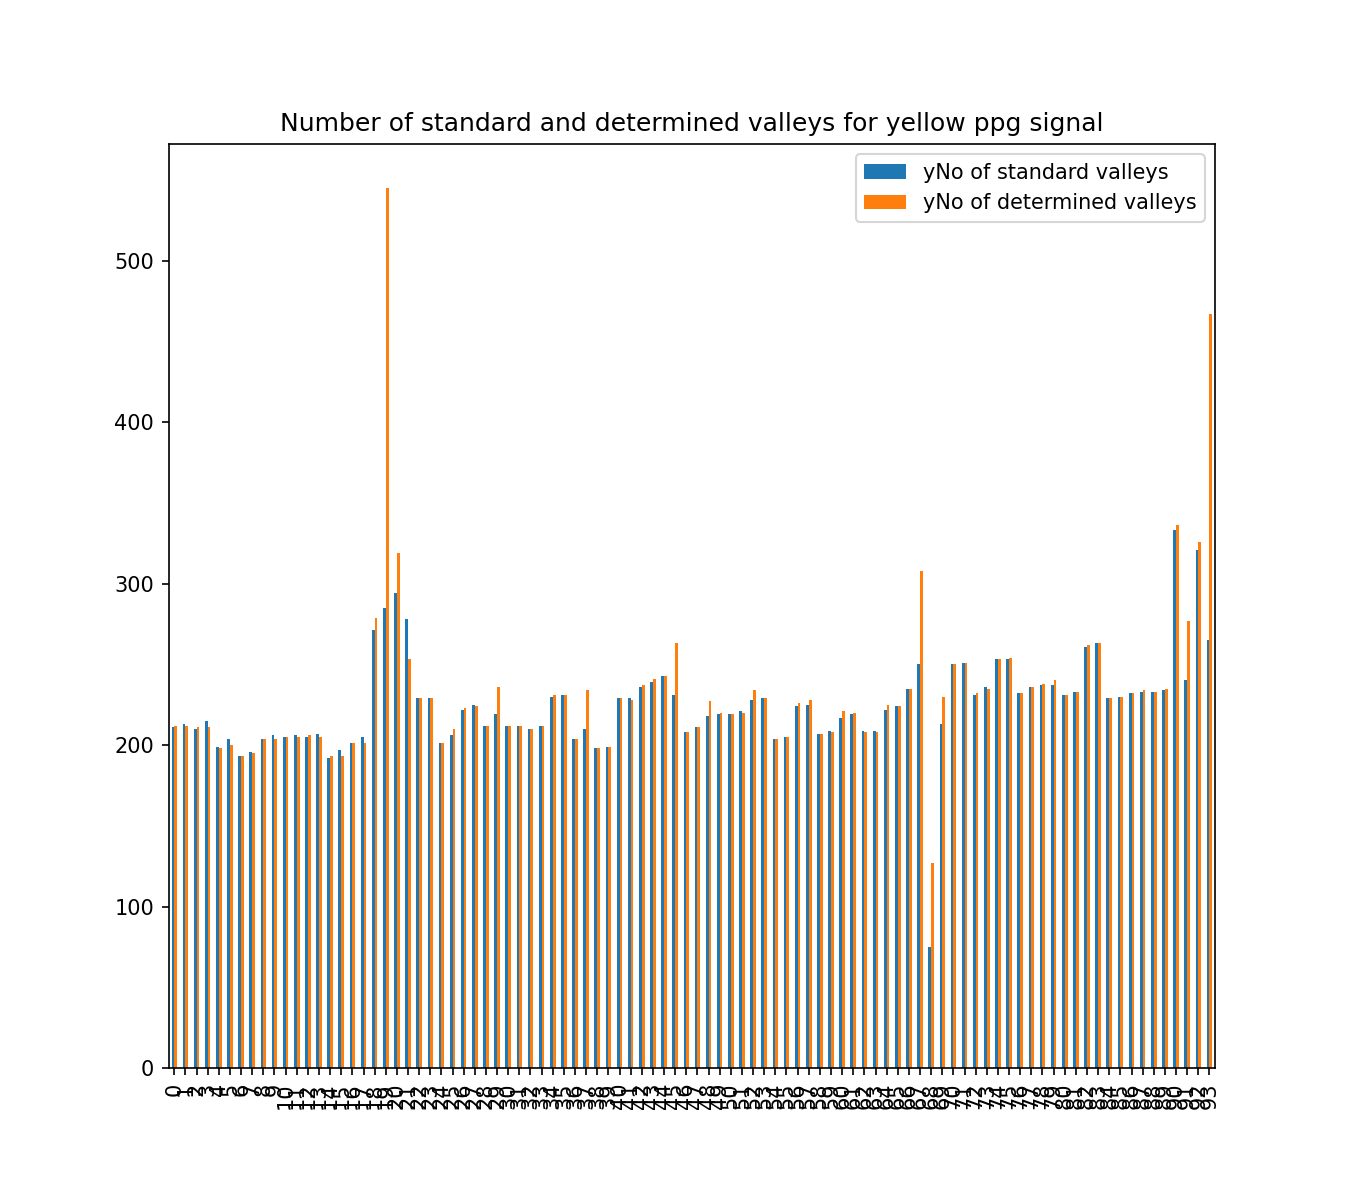

In [11]:
df.plot(y=["yNo of standard valleys", "yNo of determined valleys"], kind="bar",figsize=(9,8))
plt.title('Number of standard and determined valleys for yellow ppg signal')
plt.show()

<IPython.core.display.Javascript object>


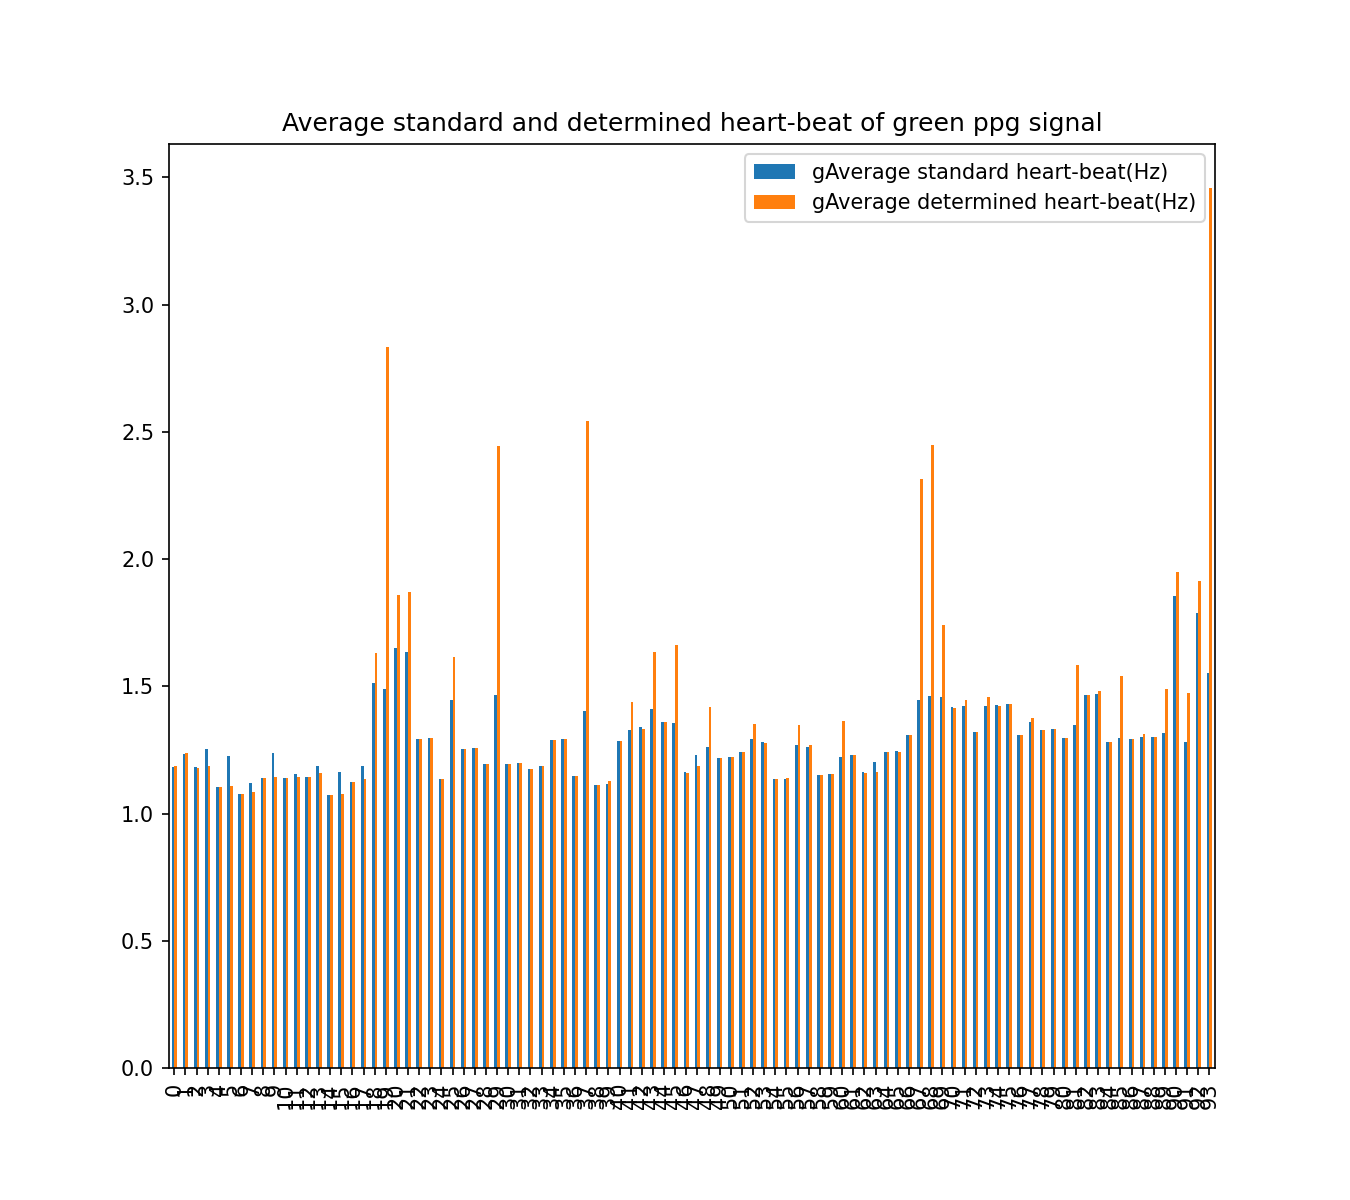

In [12]:
df.plot(y=["gAverage standard heart-beat(Hz)", "gAverage determined heart-beat(Hz)"], kind="bar",figsize=(9,8))
plt.title('Average standard and determined heart-beat of green ppg signal')
plt.show()

<IPython.core.display.Javascript object>


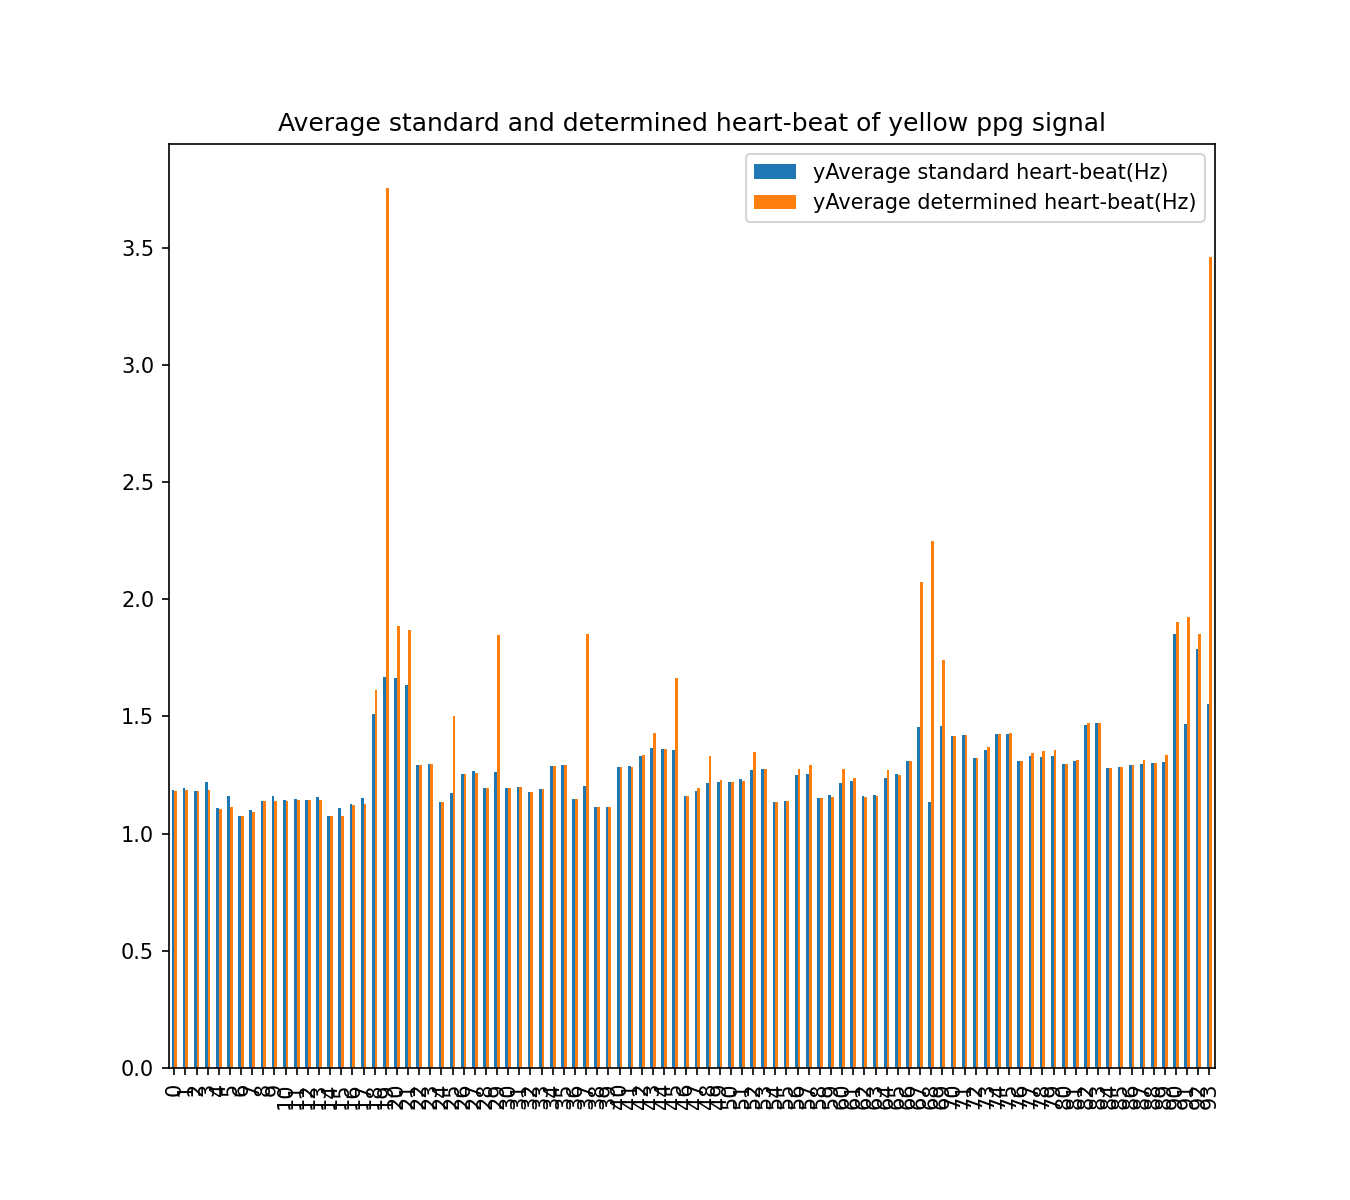

In [13]:
df.plot(y=["yAverage standard heart-beat(Hz)", "yAverage determined heart-beat(Hz)"], kind="bar",figsize=(9,8))
plt.title('Average standard and determined heart-beat of yellow ppg signal')
plt.show()

<IPython.core.display.Javascript object>


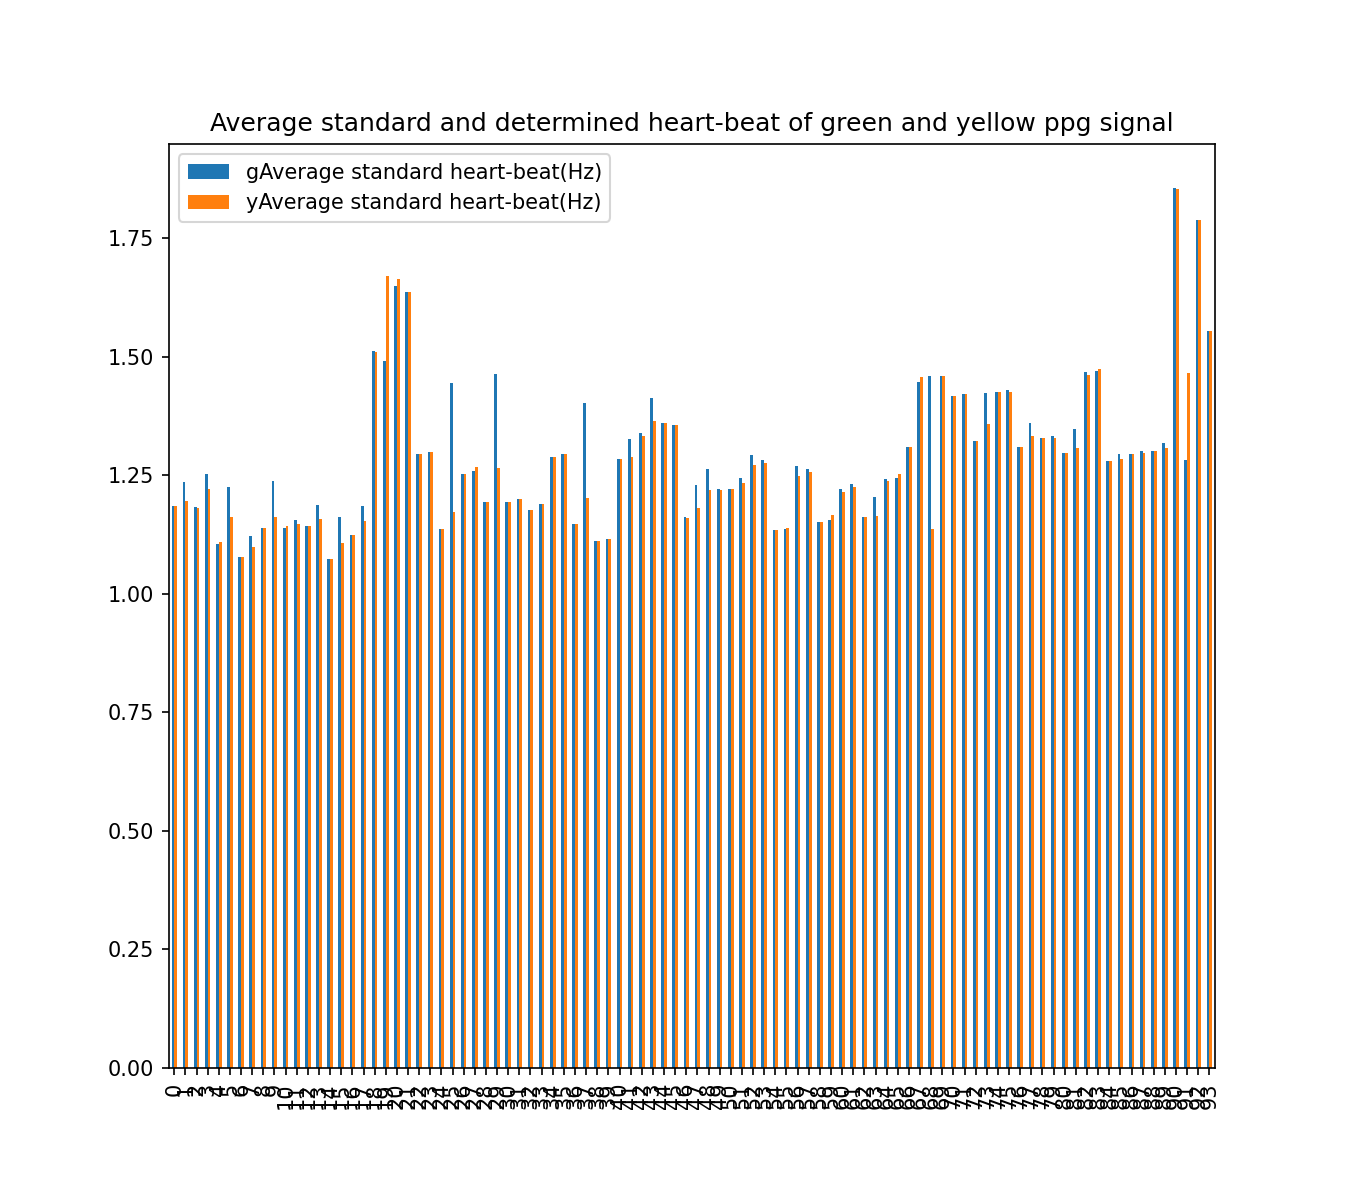

In [14]:
df.plot(y=["gAverage standard heart-beat(Hz)", "yAverage standard heart-beat(Hz)"], kind="bar",figsize=(9,8))
plt.title('Average standard and determined heart-beat of green and yellow ppg signal')
plt.show()

<IPython.core.display.Javascript object>


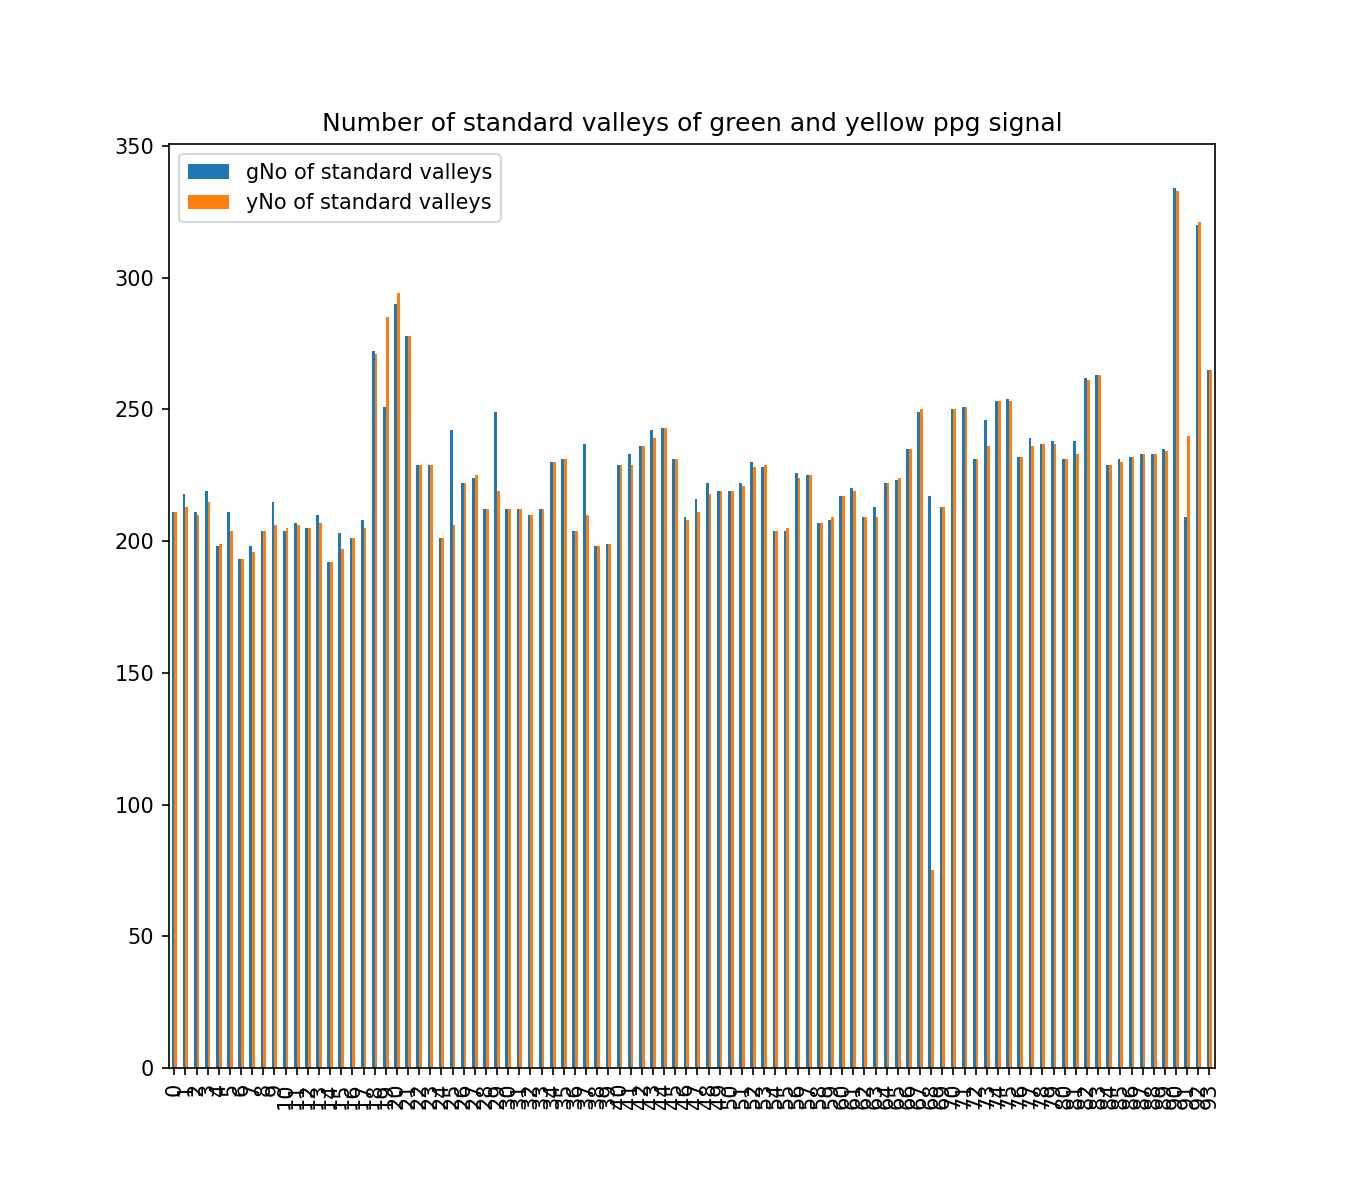

In [15]:
df.plot(y=["gNo of standard valleys", "yNo of standard valleys"], kind="bar",figsize=(9,8))
plt.title('Number of standard valleys of green and yellow ppg signal')
plt.show()

<IPython.core.display.Javascript object>


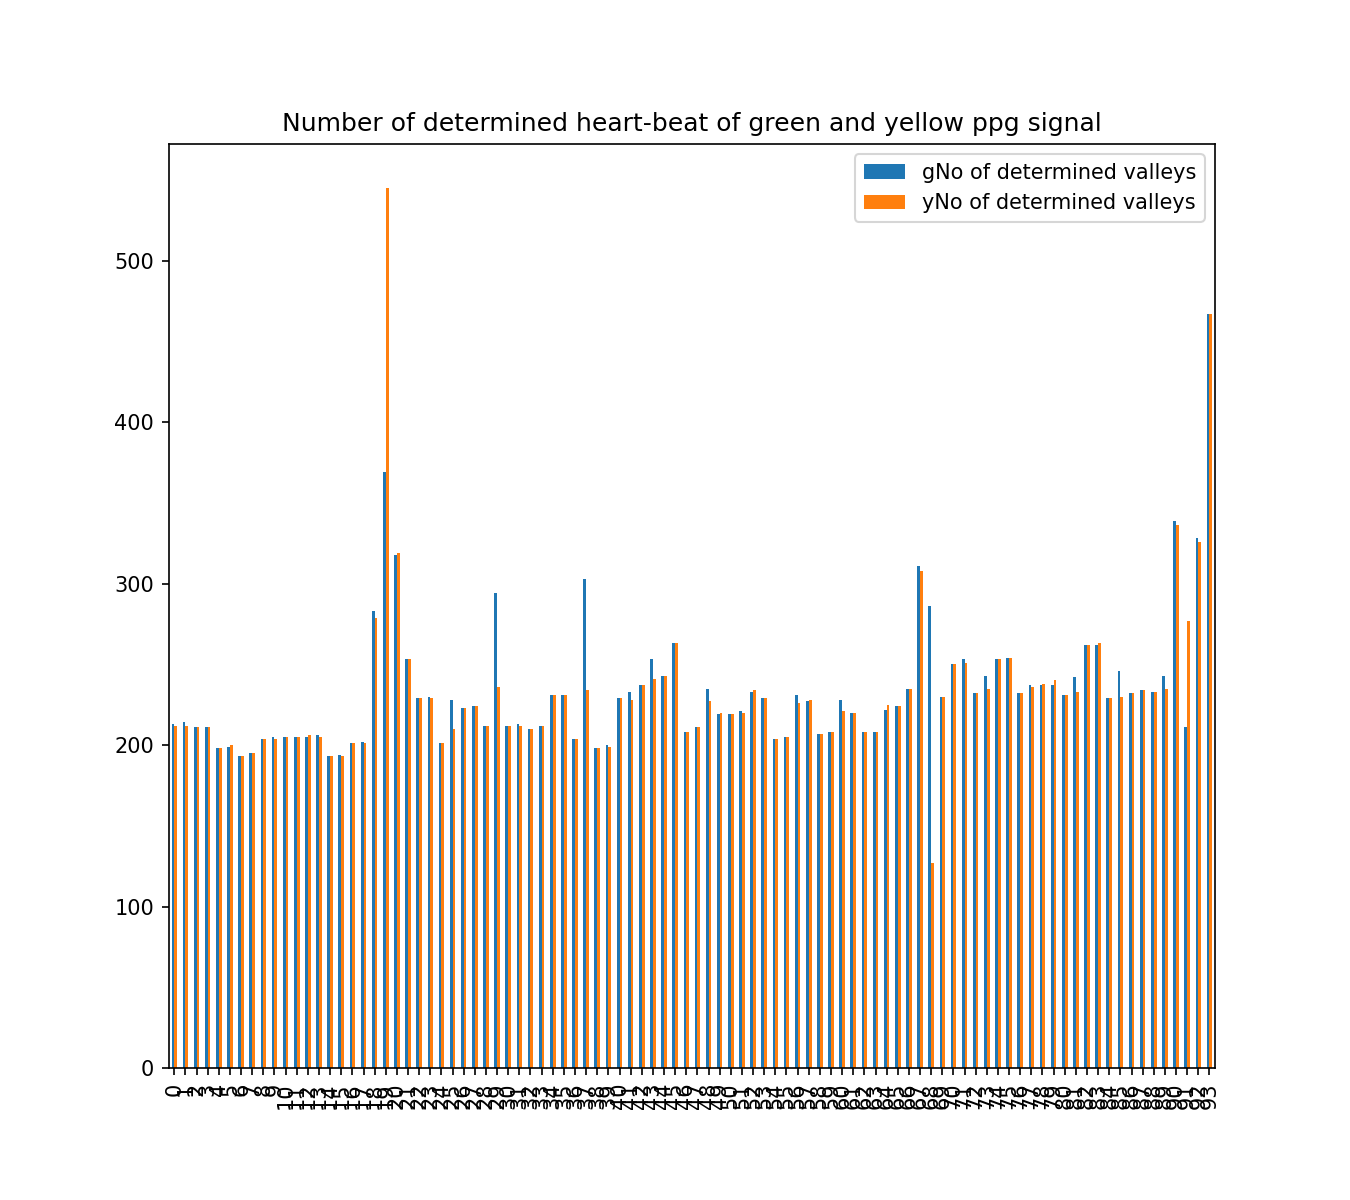

In [16]:
df.plot(y=["gNo of determined valleys", "yNo of determined valleys"], kind="bar",figsize=(9,8))
plt.title('Number of determined heart-beat of green and yellow ppg signal')
plt.show()